In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, GlobalAveragePooling2D
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d2'
nb_classes = 2
# clean = True

/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kalfasyan/anaconda3/envs/wbtf/lib/pyt

### data collecting

In [3]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [4]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [5]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [6]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    15620
0    11226
dtype: int64

val: 
1    5206
0    3743
dtype: int64

test: 
1    16340
0    15530
dtype: int64


### training

In [7]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_loss')

In [8]:
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes, extra_dense_layer=False)
model = modelconf.config

# base_output = model.layers[-2].output
# new_output = Dense(1, activation=None)(base_output)
# new_output2 = Activation('sigmoid')(new_output)
# model = Model(inputs=model.inputs, outputs=new_output2)

print("Last 5 layers:")
for i in model.layers[-5:]:
    print(i.name)

############ INPUT SHAPE:(5000, 1)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Last 5 layers:
dropout
global_average_pooling1d
dense
dense_1
activation


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4998, 16)          64        
_________________________________________________________________
batch_normalization (BatchNo (None, 4998, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2499, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2497, 32)          1568      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2497, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1248, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1246, 64)          6

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# from sklearn.utils import class_weight
# weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = {i : weights[i] for i in range(nb_classes)}
# print(class_weights)

In [12]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                    binary_labels=False),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                        binary_labels=False),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)
#              class_weight=class_weights)

Epoch 1/100
837/839 [============================>.] - ETA: 0s - loss: 0.2429 - acc: 0.8982
Epoch 00001: val_loss improved from inf to 1.49531, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_conv1d2_custom.h5
839/839 [==============================] - 69s 82ms/step - loss: 0.2429 - acc: 0.8982 - val_loss: 1.4953 - val_acc: 0.5401
Epoch 2/100
838/839 [============================>.] - ETA: 0s - loss: 0.1554 - acc: 0.9391
Epoch 00002: val_loss improved from 1.49531 to 0.24462, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_rawflt_conv1d2_custom.h5
839/839 [==============================] - 70s 83ms/step - loss: 0.1558 - acc: 0.9389 - val_loss: 0.2446 - val_acc: 0.8900
Epoch 3/100
836/839 [============================>.] - ETA: 0s - loss: 0.1195 - acc: 0.9535
Epoch 00003: val_loss did not improve from 0.24462
839/839 [==============================] - 67s 80ms/step - loss: 0.1201 - acc: 0.9533 - val_loss: 0.6762 - val_ac

In [13]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting, binary_labels=False),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [14]:
# y_pred = np.where(pred <= 0.98, 0 , 1)p
y_pred = np.argmax(pred,axis=1)

In [15]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score

balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

0.8926269958803627

Text(33.0, 0.5, 'actual')

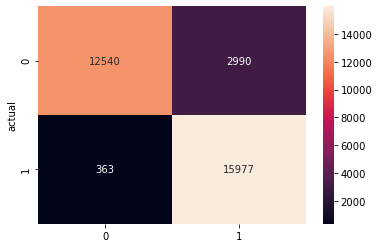

In [16]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
# cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('actual')

In [17]:
dset1 = DatasetConfiguration(names=['Suzukii_RL'])
dset1.select(name='Suzukii_RL', species=['R','L'])
dset1.read()
dset1.clean()

Dataset - Suzukii_RL - exists: True


In [18]:
dset1.labels = dset1.labels.apply(lambda x: 1)

In [25]:
dset1.fnames.shape
dset1.labels.iloc[0] = 0

In [26]:
predRL = model.predict_generator(valid_generator(dset1.fnames.tolist(), dset1.labels.tolist(),
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(dset1.labels.tolist()).tolist(),
                                    setting=traincf.setting, binary_labels=False),
                              steps=int(math.ceil(float(len(dset1.fnames.tolist()))/float(traincf.batch_size))))

In [27]:
y_predRL = np.argmax(predRL,axis=1)

In [28]:
balanced_accuracy_score(y_true=dset1.labels.tolist(), y_pred=y_predRL)

0.9692095421371774